In [1]:
# !pip install pandas pyarrow fastparquet
!pip install scikit-learn

In [2]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
folder = Path(r"C:/Users/Dasha/Documents/project ML/enriched_data") 
files = list(folder.glob("part-*.parquet"))

df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)


df = df.astype({
    "department": "str",
    "product_id": "int",
    "order_id": "int",
    "add_to_cart_order": "int",
    "reordered": "int",
    "department_id": "int",
    "aisle_id": "int", 
    "product_name": "str", 
    "avg_price": "int"    
})

df.head()

,department,product_id,order_id,add_to_cart_order,reordered,department_id,aisle_id,product_name,aisle,avg_price
0,pantry,30064,188723,2,0,13,17,Double Acting Baking Powder,baking ingredients,2
1,produce,38557,124150,9,0,4,24,Citrus Mandarins Organic,fresh fruits,1
2,produce,13176,539689,2,1,4,24,Bag of Organic Bananas,fresh fruits,1
3,babies,2611,544204,1,1,18,92,Gluten Free SpongeBob Spinach Littles,baby food formula,2
4,pantry,18441,4707,1,0,13,72,Organic Ketchup,condiments,2


In [4]:
base_path = r"C:/Users/Dasha/Documents/project ML/data/raw"

orders = pd.read_csv(os.path.join(base_path, "orders.csv"))
# order_products = pd.read_csv(os.path.join(BASE_PATH, "order_products__prior.csv"))
# order_products_train = pd.read_csv(os.path.join(BASE_PATH, "order_products__train.csv"))
# products = pd.read_csv(os.path.join(BASE_PATH, "products.csv"))
# aisles = pd.read_csv(os.path.join(BASE_PATH, "aisles.csv"))
# departments = pd.read_csv(os.path.join(BASE_PATH, "departments.csv"))

In [5]:
# calculating the metrics

df_joined = df.merge(orders, on = "order_id", how = "left")
df_joined.head()
df_joined["days_since_prior_order"] = df_joined["days_since_prior_order"].fillna(0)# basket features
# basket variety

## Basket-size segmetation

### By average basket size

In [6]:
basket_df = (
    df_joined.groupby("user_id")
    .agg(
        total_sales = ("avg_price", "sum"), 
        number_sales = ("order_id", "count")
    )
    .reset_index()
)

basket_df["avg_basket_size"] = basket_df["total_sales"] / basket_df["number_sales"]
basket_df.head()

,user_id,total_sales,number_sales,avg_basket_size
0,1,13,7,1.857143
1,2,24,14,1.714286
2,3,17,10,1.700000
3,4,3,1,3.000000
4,5,4,4,1.000000


In [7]:
X = basket_df[["avg_basket_size"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

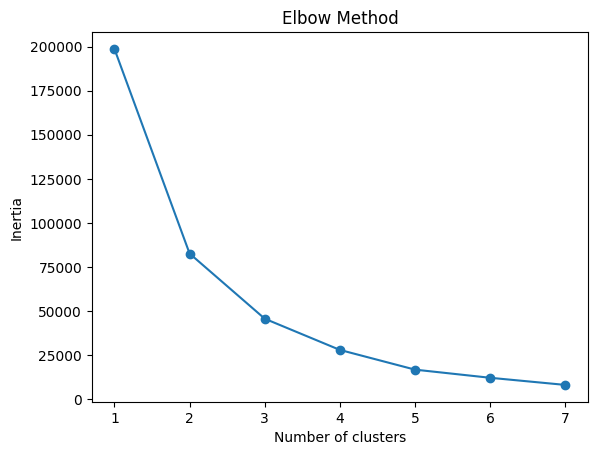

In [8]:
inertia = []

for k in range(1, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 8), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

basket_df["cluster"] = kmeans.fit_predict(X_scaled)

In [10]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

centers_df = pd.DataFrame(
    centers,
    columns=["avg_basket_size"]
)

centers_df["cluster"] = centers_df.index
centers_df

,avg_basket_size,cluster
0,1.651270,0
1,2.046448,1
2,1.221347,2


In [11]:
centers_df = centers_df.sort_values("avg_basket_size")

label_map = {
    centers_df.iloc[0]["cluster"]: "Budget shoppers",
    centers_df.iloc[1]["cluster"]: "Mid-range shoppers",
    centers_df.iloc[2]["cluster"]: "Premium shoppers"
}

basket_df["segment"] = basket_df["cluster"].map(label_map)

In [12]:
basket_df.groupby("segment")["avg_basket_size"].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Budget shoppers,35279.0,1.221487,0.162274,1.000000,1.000000,1.266667,1.36,1.435897
Mid-range shoppers,101939.0,1.651320,0.112992,1.436364,1.555556,1.666667,1.75,1.848739
Premium shoppers,61462.0,2.046452,0.199682,1.848889,1.952381,2.000000,2.00,3.000000


In [30]:
basket_df.to_csv('basket_df', index = False)

### By baskiet size variability

In [13]:
basket_per_order = (
    df_joined.groupby(["user_id", "order_id"])
      .agg(order_value=("avg_price", "sum"))
      .reset_index()
)

basket_variability = (
    basket_per_order.groupby("user_id")
                    .agg(
                        basket_std=("order_value", "std"),
                        total_orders=("order_id", "count")
                    )
                    .reset_index()
)

basket_variability["basket_std"] = basket_variability["basket_std"].fillna(0)

In [14]:
X = basket_variability[["basket_std"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
basket_variability["cluster"] = kmeans.fit_predict(X_scaled)

# Map clusters to Low / High variability
centers = scaler.inverse_transform(kmeans.cluster_centers_)
if centers[0][0] < centers[1][0]:
    label_map = {0: "Low variability", 1: "High variability"}
else:
    label_map = {0: "High variability", 1: "Low variability"}

basket_variability["variability_segment"] = basket_variability["cluster"].map(label_map)

In [15]:
basket_variability.groupby("variability_segment")["basket_std"].describe()

,count,mean,std,min,25%,50%,75%,max
variability_segment,,,,,,,,
High variability,73379.0,2.429735,0.782701,1.615452,1.892969,2.188122,2.738613,11.528949
Low variability,125301.0,0.800438,0.535102,0.000000,0.468807,0.873212,1.264911,1.615200


In [31]:
basket_variability.to_csv('basket_variability', index = False)

## Regular VS Irregular clients segmentation

In [16]:
user_regularity = (
    df_joined.groupby("user_id")
      .agg(
          avg_days_between_orders=("days_since_prior_order", "mean"),
          std_days_between_orders=("days_since_prior_order", "std"),
          total_orders=("order_id", "count")
      )
      .reset_index()
)

user_regularity["std_days_between_orders"] = user_regularity["std_days_between_orders"].fillna(0)

In [17]:
X = user_regularity[["avg_days_between_orders", "std_days_between_orders"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
user_regularity["cluster"] = kmeans.fit_predict(X_scaled)

In [18]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
# Find cluster with smallest avg_days_between_orders → Regular
label_map = {0: "Irregular", 1: "Regular"}  # adjust based on centers
user_regularity["segment"] = user_regularity["cluster"].map(label_map)

In [19]:
user_regularity.groupby("segment")["avg_days_between_orders"].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
Irregular,106622.0,17.893557,5.679189,5.8,13.611111,16.75,21.4,30.0
Regular,92058.0,7.257598,3.571582,0.0,5.000000,7.25,9.4,21.0


In [32]:
user_regularity.to_csv('user_regularity', index = False)

### Common table

In [20]:
# Merge all segments
user_segments = (
    basket_df[["user_id", "segment"]].rename(columns={"segment": "basket_segment"})
    .merge(basket_variability[["user_id", "variability_segment"]], on="user_id", how="left")
    .merge(user_regularity[["user_id", "segment"]].rename(columns={"segment": "regularity_segment"}), on="user_id", how="left")
)

user_segments.head()

,user_id,basket_segment,variability_segment,regularity_segment
0,1,Premium shoppers,Low variability,Irregular
1,2,Mid-range shoppers,Low variability,Irregular
2,3,Mid-range shoppers,Low variability,Regular
3,4,Premium shoppers,Low variability,Regular
4,5,Budget shoppers,Low variability,Regular


In [33]:
user_segments.to_csv('user_segments', index = False)

## RFM-Analysis

In [21]:
rfm_dataset = df_joined.groupby('user_id').agg({
    'days_since_prior_order': 'last', 
    'order_id': 'count', 
    'avg_price': 'sum'
}).rename(columns = {
    'days_since_prior_order': 'recency', 
    'order_id': 'frequency', 
    'avg_price': 'monetary'
})

rfm_dataset.head()

,recency,frequency,monetary
user_id,,,
1,19.0,7,13
2,13.0,14,24
3,0.0,10,17
4,0.0,1,3
5,10.0,4,4


In [22]:
r = pd.qcut(rfm_dataset['recency'].rank(method='first'), 
            q=5, 
            labels=range(5, 0, -1))

f = pd.qcut(rfm_dataset['frequency'], 
            q=5, 
            labels=range(1, 6),  
            duplicates='drop')

m = pd.qcut(rfm_dataset['monetary'], 
            q=5, 
            labels=range(1, 6),  # Fixed function name
            duplicates='drop')

rfm = rfm_dataset.assign(R=r.values, F=f.values, M=m.values)
# replace with a zero

In [23]:
# temporary solution for NaN values
rfm[['R', 'F', 'M']].isna().sum()
rfm[['R', 'F', 'M']] = rfm[['R', 'F', 'M']].fillna(1).astype(int)


In [24]:
rfm['rfm_group'] = rfm[['R', 'F', 'M']].apply(lambda v:'-'.join(v.astype(str)), axis = 1)
rfm['rfm_score_total'] = rfm[['R', 'F', 'M']].sum(axis=1)

In [25]:
rfm.sort_values(by='rfm_score_total', ascending=False).head()


,recency,frequency,monetary,R,F,M,rfm_group,rfm_score_total
user_id,,,,,,,,
121714,1.0,67,91,5,5,5,5-5-5,15
51161,3.0,29,48,5,5,5,5-5-5,15
51141,3.0,74,115,5,5,5,5-5-5,15
125828,2.0,53,98,5,5,5,5-5-5,15
132006,2.0,114,160,5,5,5,5-5-5,15


In [26]:
rfm["rfm_score_total"].unique()
# need to segment them equally

# k-mean
# clustering

array([ 7, 11,  6, 13,  4, 10,  9,  8,  3, 15, 14,  5, 12])

In [27]:
all_rfm = (
    rfm.sort_values(by="rfm_score_total", ascending=False)
)

all_rfm.to_csv("top_rfm.csv", index=False)
# which one among the customers is gone, he s frequency, basket size, customer size
# shiny apps
# people ehy buy the most = time betweem the last buy is it increasing or not, do they cone back freauently
# make a drill dowm
# average engagemnt of th exustomer,vetween each boutgh, where is a max, if there was a lot of time since last order, send the notification to the customer
#  explain the differences between the mecanismes the dataset was selected that way that are the rules thtat we eant to recommend to the owner, 